In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Libraries imported successfully")




Libraries imported successfully


In [29]:
# Load waveform and features CSVs
waveform_path = "../Data/processed/biomedical_preprocessed.csv"
features_path = "../Data/processed/ppg_features.csv"

wave_df = pd.read_csv(waveform_path)
feat_df = pd.read_csv(features_path)

print("Waveform CSV shape:", wave_df.shape)
print("Features CSV shape:", feat_df.shape)



Waveform CSV shape: (1458152, 28)
Features CSV shape: (1158, 13)


In [30]:
# Cell 3: Window parameters
fs = 500                 # Sampling frequency
window_sec = 5           # Window size in seconds
window_samples = fs * window_sec
print("Window samples:", window_samples)




Window samples: 2500


In [31]:
# Cell 4: Create 5-sec windows from pleth_3_filt and assign window_idx
# Collect windows for pleth_3_filt + accelerometer channels
X_list = []
window_info = []

acc_channels = ['a_x_filt','a_y_filt','a_z_filt']
ppg_channel = 'pleth_3_filt'

for subject in wave_df['subject_id'].unique():
    subj_df = wave_df[wave_df['subject_id'] == subject].reset_index(drop=True)
    ppg_signal = subj_df[ppg_channel].values
    acc_signal = subj_df[acc_channels].values

    n_windows = len(ppg_signal) // window_samples
    for w in range(n_windows):
        start = w * window_samples
        end = start + window_samples

        # Combine PPG + accel as multi-channel input
        window_data = np.column_stack([ppg_signal[start:end], acc_signal[start:end, :]])
        X_list.append(window_data)
        window_info.append({'subject_id': subject, 'window_idx': w})

X = np.array(X_list)
window_info_df = pd.DataFrame(window_info)

print("X shape (samples, timesteps, channels):", X.shape)
window_info_df.head()




X shape (samples, timesteps, channels): (582, 2500, 4)


,subject_id,window_idx
0,s12,0
1,s12,1
2,s12,2
3,s12,3
4,s12,4


In [32]:
# Cell 5: Prepare window_idx in features CSV
feat_df_sorted = feat_df.sort_values('subject_id').reset_index(drop=True)
feat_df_sorted['window_idx'] = feat_df_sorted.groupby('subject_id').cumcount()
feat_df_sorted.head()



,subject_id,activity,hr_bpm,hrv,peak_count,R_ratio,red_ac,ir_ac,ppg_mean,ppg_std,ppg_rms,ppg_energy,ppg_entropy,window_idx
0,s12,run,99.709182,0.007644,9,1.580212,98.586438,256.296416,-1.116858,68.371286,68.380407,1.168347e+07,1.845303,0
1,s12,sit,71.839080,0.014344,6,0.149413,115.321429,284.392610,0.003660,93.606604,93.606604,2.188798e+07,0.673617,1
2,s12,sit,71.462601,0.012290,6,0.935837,112.748578,281.620632,1.197835,92.728682,92.736418,2.148651e+07,0.776565,2
3,s12,sit,72.674419,0.003200,6,0.873124,117.836296,286.571404,2.148075,91.465008,91.490228,2.092095e+07,0.818232,3
4,s12,walk,93.959732,0.010012,8,0.975157,94.621171,204.035882,1.809098,22.527098,22.599623,1.284012e+06,1.991326,4


In [33]:
# Cell 6: Merge waveform windows with HR and SpO2
merged_df = window_info_df.merge(
    feat_df_sorted[['subject_id','window_idx','hr_bpm','R_ratio']],
    on=['subject_id','window_idx'],
    how='inner'
)

# Align X and y
X_aligned = X[merged_df.index.values]
y_aligned = merged_df[['hr_bpm','R_ratio']].values

print("Aligned X shape:", X_aligned.shape)
print("Aligned y shape:", y_aligned.shape)
merged_df.head()



Aligned X shape: (582, 2500, 4)
Aligned y shape: (582, 2)


,subject_id,window_idx,hr_bpm,R_ratio
0,s12,0,99.709182,1.580212
1,s12,1,71.839080,0.149413
2,s12,2,71.462601,0.935837
3,s12,3,72.674419,0.873124
4,s12,4,93.959732,0.975157


In [34]:
#NORMALIZE TARGETS
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_aligned)
print("First 5 normalized targets:\n", y_scaled[:5])


First 5 normalized targets:
 [[0.68253736 0.60233312]
 [0.08645925 0.54894022]
 [0.07840722 0.57828707]
 [0.10432523 0.57594685]
 [0.55956969 0.57975437]]


In [35]:
#TRAIN TEST SPLIT
subjects = merged_df['subject_id'].unique()
train_subjects = subjects[:int(0.7*len(subjects))]
test_subjects  = subjects[int(0.7*len(subjects)):]

train_idx = merged_df['subject_id'].isin(train_subjects)
test_idx  = merged_df['subject_id'].isin(test_subjects)

X_train = X_aligned[train_idx.values]
X_test  = X_aligned[test_idx.values]
y_train = y_scaled[train_idx.values]
y_test  = y_scaled[test_idx.values]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (291, 2500, 4)
y_train shape: (291, 2)
X_test shape: (291, 2500, 4)
y_test shape: (291, 2)


In [36]:
#1D CNN MODEL
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(window_samples, 4)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='linear')  # HR and SpO₂
])

model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
model.summary()


C:\Users\n\Desktop\Intelligent Health Monitoring\.venv2\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 2496, 32)       │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1248, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1244, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 622, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 618, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 309, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 39552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,531,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,583,586 (9.86 MB)

 Trainable params: 2,583,586 (9.86 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Cell 10: Train CNN with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - loss: 4238.2939 - mae: 23.8707 - val_loss: 0.2441 - val_mae: 0.4228
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - loss: 0.2791 - mae: 0.4388 - val_loss: 0.1710 - val_mae: 0.4044
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - loss: 0.2156 - mae: 0.3749 - val_loss: 0.2143 - val_mae: 0.4531
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - loss: 0.1449 - mae: 0.3232 - val_loss: 0.2032 - val_mae: 0.4417
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - loss: 0.1002 - mae: 0.2629 - val_loss: 0.1494 - val_mae: 0.3782
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - loss: 0.0903 - mae: 0.2430 - val_loss: 0.1601 - val_mae: 0.3912
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - loss: 0.0872 - mae: 0.2401 - val_loss: 0.1671 - val_mae: 0.3989
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 0.0939 - mae: 0.2446 - val_loss: 0.1630 - val_mae: 0.3934
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step

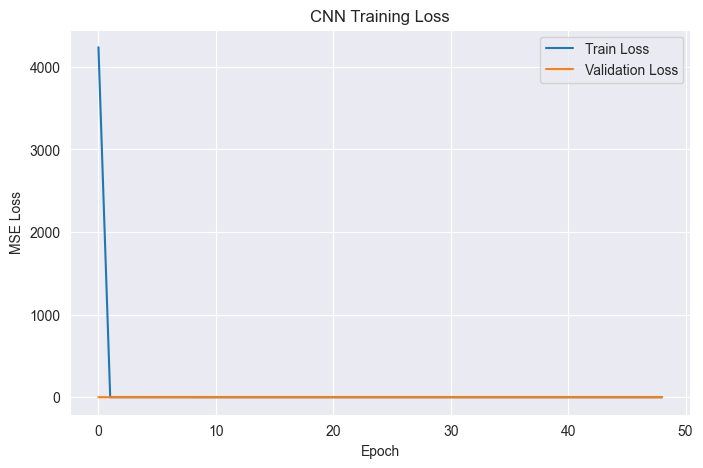

In [38]:
# Cell 11: Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('CNN Training Loss')
plt.legend()
plt.show()



In [39]:
# Cell 12 (Edited): Inverse transform predictions to original scale
# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test)

# Compute MAE for HR and SpO₂ separately
mae_hr = mean_absolute_error(y_test_real[:,0], y_pred[:,0])
mae_spo2 = mean_absolute_error(y_test_real[:,1], y_pred[:,1])

print(f"Test MAE (HR): {mae_hr:.2f} bpm")
print(f"Test MAE (SpO₂): {mae_spo2:.2f} (R_ratio units)")




10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Test MAE (HR): 14.24 bpm
Test MAE (SpO₂): 6.21 (R_ratio units)


C:\Users\n\AppData\Local\Temp\ipykernel_10900\228832202.py:22: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\n\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


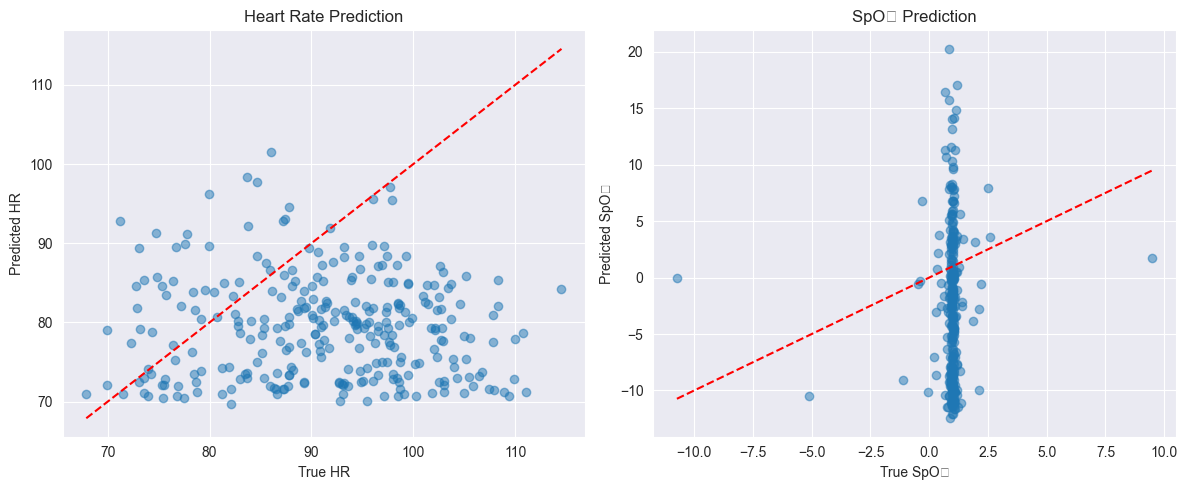

In [40]:
# Cell 13: Predictions vs true values
plt.figure(figsize=(12,5))

# HR subplot
plt.subplot(1,2,1)
plt.scatter(y_test_real[:,0], y_pred[:,0], alpha=0.5)
plt.plot([y_test_real[:,0].min(), y_test_real[:,0].max()],
         [y_test_real[:,0].min(), y_test_real[:,0].max()], 'r--')
plt.xlabel("True HR")
plt.ylabel("Predicted HR")
plt.title("Heart Rate Prediction")

# SpO2 subplot
plt.subplot(1,2,2)
plt.scatter(y_test_real[:,1], y_pred[:,1], alpha=0.5)
plt.plot([y_test_real[:,1].min(), y_test_real[:,1].max()],
         [y_test_real[:,1].min(), y_test_real[:,1].max()], 'r--')
plt.xlabel("True SpO₂")
plt.ylabel("Predicted SpO₂")
plt.title("SpO₂ Prediction")

plt.tight_layout()
plt.show()
